# TP1 - Redes Neuronales (22.45)

En este trabajo páctico se busca armar una red neuronal capaz de obtener el mayor acuracy para lograr la mejor posición en la competencia de Kaggle. Se utiliza el dataset "cifar-100" y todos los conocimientos vistos en clase para la realización de la red capaz de identificar las fotos dentro del dataset.

*Autor: Nicolás Bustelo - 61431*

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.utils import plot_model

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/itba-rn-2245-cifar-100-2023q2/y_train_fine.npy
/kaggle/input/itba-rn-2245-cifar-100-2023q2/y_train_coarse.npy
/kaggle/input/itba-rn-2245-cifar-100-2023q2/fine_label_names.pck
/kaggle/input/itba-rn-2245-cifar-100-2023q2/coarse_label_names.pck
/kaggle/input/itba-rn-2245-cifar-100-2023q2/x_test.npy
/kaggle/input/itba-rn-2245-cifar-100-2023q2/x_train.npy


## Dataset load

In [2]:
x_train = np.load("/kaggle/input/itba-rn-2245-cifar-100-2023q2/x_train.npy")/255.
x_test = np.load("/kaggle/input/itba-rn-2245-cifar-100-2023q2/x_test.npy")/255.
y_train_coarse = np.load("/kaggle/input/itba-rn-2245-cifar-100-2023q2/y_train_coarse.npy")
y_train_fine = np.load("/kaggle/input/itba-rn-2245-cifar-100-2023q2/y_train_fine.npy")

In [3]:
import pickle
with open("/kaggle/input/itba-rn-2245-cifar-100-2023q2/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/itba-rn-2245-cifar-100-2023q2/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [4]:
from matplotlib import pyplot as plt

## Dataset sample viewing

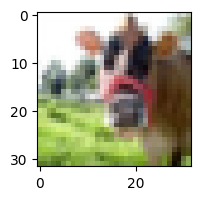

In [5]:
plt.figure(figsize=(2,2))
plt.imshow(x_train[0])

In [6]:
labels_coarse[11]

'large_omnivores_and_herbivores'

### Data convert to GreyScale: 
grayImages es el vector con todas las imagenes en escala de grises.

51200000

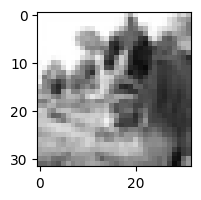

In [7]:
grayImages = np.dot(x_train[...,:3], [0.2989, 0.5870, 0.1140])
plt.figure(figsize=(2,2))
plt.imshow(grayImages[0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
grayImages.size

In [8]:
# Me fijo para una categoría de grano grueso, cuáles son las categorías de grano fino
coarse = 11
print(f"Grano grueso: {labels_coarse[coarse]}")
for fine in np.unique(y_train_fine[y_train_coarse == coarse]):
    print(f"Grano fino: {labels_fine[fine]}")

Grano grueso: large_omnivores_and_herbivores
Grano fino: camel
Grano fino: cattle
Grano fino: chimpanzee
Grano fino: elephant
Grano fino: kangaroo


## Model Training:

In [9]:
# Importo las bibliotecas a utilizar
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

**Ecplicar un poco mejor las capas de la red**

Flatten es la capa de entrada

El relu es la hidden layer -> 

Softmax -> Capa de salida transforma los números a probabilidades

In [10]:
model = Sequential()
#hacer un optimizer...
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(512, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1), kernel_constraint=MaxNorm(5)))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1), kernel_constraint=MaxNorm(5)))
model.add(Dropout(0.1))
model.add(Dense(512, activation='sigmoid', kernel_constraint=MaxNorm(5)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0

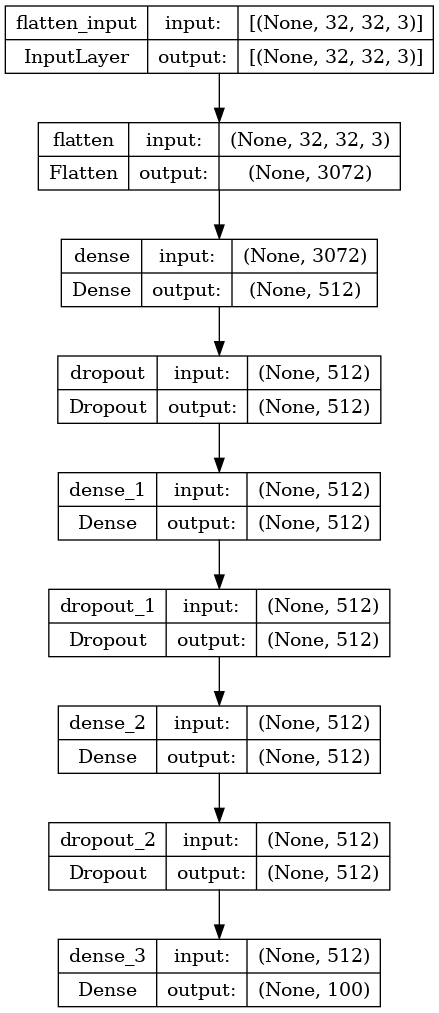

In [12]:
plot_model(model,show_shapes=True,show_layer_names=True)

### Callbacks:

In [13]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 5,
    verbose = 1,
    min_lr = 1e-5
)

In [14]:
mc = ModelCheckpoint(
    "best_weights.hfd5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [15]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 15, 
    verbose = 1,
    restore_best_weights = True,
)

In [16]:
tb = TensorBoard(
    log_dir="logs",
)

### Entreno el modelo:

In [17]:
history = model.fit(
    x = x_train, 
    y = y_train_fine, 
    batch_size=1024, 
    epochs=200, 
    validation_split = 0.2, 
    callbacks= [
        rlrop,
        es,
        mc,
        tb,
    ]
)

Epoch 1/200
37/40 [==========================>...] - ETA: 0s - loss: 4.4438 - accuracy: 0.0375
Epoch 1: val_accuracy improved from -inf to 0.07230, saving model to best_weights.hfd5
40/40 [==============================] - 6s 31ms/step - loss: 4.4286 - accuracy: 0.0391 - val_loss: 4.0998 - val_accuracy: 0.0723 - lr: 0.0010
Epoch 2/200
36/40 [==========================>...] - ETA: 0s - loss: 4.0208 - accuracy: 0.0891
Epoch 2: val_accuracy improved from 0.07230 to 0.10900, saving model to best_weights.hfd5
40/40 [==============================] - 1s 18ms/step - loss: 4.0087 - accuracy: 0.0909 - val_loss: 3.8599 - val_accuracy: 0.1090 - lr: 0.0010
Epoch 3/200
40/40 [==============================] - ETA: 0s - loss: 3.8002 - accuracy: 0.1227
Epoch 3: val_accuracy improved from 0.10900 to 0.13470, saving model to best_weights.hfd5
40/40 [==============================] - 1s 17ms/step - loss: 3.8002 - accuracy: 0.1227 - val_loss: 3.7484 - val_accuracy: 0.1347 - lr: 0.0010
Epoch 4/200
38/40 [

## Results

Se probaron diferentes modelos y el mejor resultado se muestra a continuación.

In [18]:
last_valacc = history.history['val_accuracy'][-1]*100
print("Last Validation Accuracy:" , format(last_valacc, ".2f"), "%")
last_acc = history.history['accuracy'][-1]*100
print("Last Accuracy:" , format(last_acc, ".2f"), "%")

Last Validation Accuracy: 28.30 %
Last Accuracy: 54.29 %


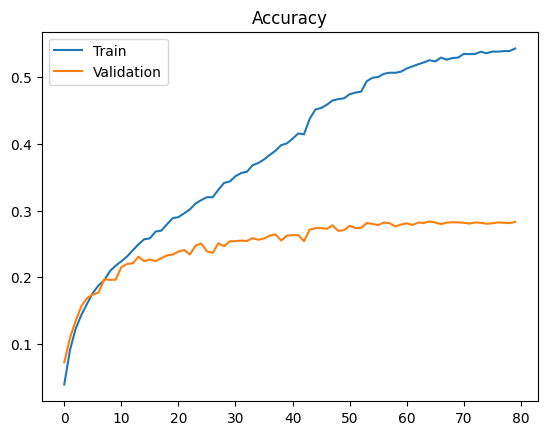

In [19]:
plt.plot(history.history["accuracy"], label='Train')
plt.plot(history.history["val_accuracy"], label='Validation')
plt.title("Accuracy")
plt.legend()

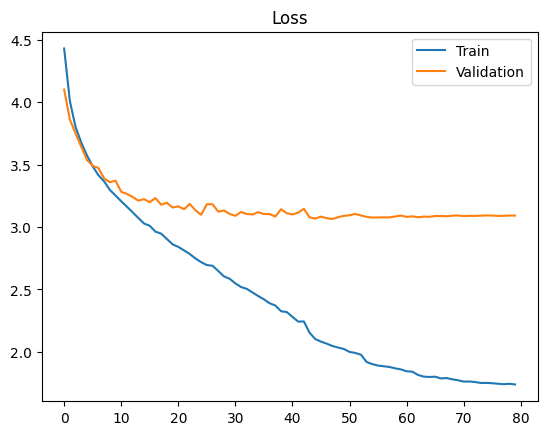

In [20]:
plt.plot(history.history["loss"], label='Train')
plt.plot(history.history["val_loss"], label='Validation')
plt.title("Loss")
plt.legend()

## Submissions generator



In [21]:
predictions = model.predict(x_test).argmax(axis=1)

313/313 [==============================] - 1s 2ms/step


In [22]:
df = pd.DataFrame(predictions, columns=["Label"])
df.index.name = "Id"
df.to_csv("submission.csv")